In [1]:
import rasterio
import geopandas as gpd
import pandas as pd
from rasterio import mask
from shapely.geometry import shape
import json
import numpy as np
from tqdm import tqdm
from random import randint
import random

C:\ProgramData\Anaconda3\lib\site-packages\geopandas\_compat.py:115: UserWarning: The Shapely GEOS version (3.4.3-CAPI-1.8.3 r4285) is incompatible with the GEOS version PyGEOS was compiled with (3.10.0-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
def __make_the_crop(load_shape, raster_path, raster_path_cropped):
    """
        This crops the sattelite image with a chosen shape.

        TODO: Make this accept a object of geopandas or shapely and crs independant.
        @param load_schape: path to a geojson shape file.
        @param raster_path_wgs: path to the raster .tiff file.
        @param raster_path_cropped: path were the cropped raster will be stored.
    """
    geo_file = gpd.read_file(load_shape)
    src = rasterio.open(raster_path)

    # Change the crs to rijks driehoek, because all the satelliet images are in rijks driehoek
    if geo_file.crs != 'epsg:28992':
        geo_file = geo_file.to_crs(epsg=28992)

    out_image, out_transform = rasterio.mask.mask(src,geo_file['geometry'], crop=True, filled=True)
    out_meta = src.meta

    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

    with rasterio.open(raster_path_cropped, "w", **out_meta) as dest:
            dest.write(out_image)
            dest.close()

# Cut .tif image into shapes based on labels.

In [3]:
tif_file = "E:/data/waterleidingduinen/20190729_111526_SV1-04_50cm_RD_11bit_RGBI_Lisse_waterleidingduin_aaneensluitende_polygon_cropped__ndvi_ahn.tif"

In [4]:
src = rasterio.open(tif_file)

In [63]:
src.read()

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint16)

In [5]:
struco_codes = pd.read_csv("C:/repos/waterleiding_annotaties/AWD_Struco_codes.csv", sep=";")

In [6]:
struco_codes

,Struco,Label
0,0,"Water, Overig"
1,10,Zand
2,20,Mos
3,30,Lage kruiden-gras
4,40,Hoge kruiden-gras
5,50,Open laag struweel
6,51,Dicht laag struweel
7,60,Open Duindoorn
8,61,Dicht Duindoorn
9,70,Open Hoog Struweel


In [8]:
gdf = gpd.read_file("E:/data/waterleidingduinen/AWD_vegetatiekartering_2016_2018_dissolve.shp")

In [9]:
gdf['Struco'] = gdf['Struco'].astype(int)

In [10]:
gdf = gdf.merge(struco_codes, on="Struco")

In [11]:
gdf

,Struco,geometry,Label
0,20,"MULTIPOLYGON (((93468.281 477863.716, 93471.58...",Mos
1,50,"MULTIPOLYGON (((93090.931 477908.638, 93092.41...",Open laag struweel
2,10,"MULTIPOLYGON (((93280.478 477754.144, 93283.01...",Zand
3,60,"MULTIPOLYGON (((93342.346 477720.225, 93345.32...",Open Duindoorn
4,61,"MULTIPOLYGON (((93493.644 477825.265, 93493.24...",Dicht Duindoorn
5,30,"MULTIPOLYGON (((93438.025 477696.898, 93440.56...",Lage kruiden-gras
6,40,"MULTIPOLYGON (((93431.139 477658.021, 93426.05...",Hoge kruiden-gras
7,51,"MULTIPOLYGON (((93184.561 478067.038, 93186.09...",Dicht laag struweel
8,70,"MULTIPOLYGON (((93223.830 478065.160, 93220.65...",Open Hoog Struweel
9,71,"MULTIPOLYGON (((92945.727 477985.050, 92946.78...",Dicht Hoog Struweel


In [37]:
for xid,row in gdf.iterrows():
    
    out_image, out_transform = rasterio.mask.mask(src, row['geometry'], crop=True, filled=True)
    out_meta = src.meta
    
    data_src =src.read() 
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    
    print(tif_file.replace(".tif","_"+str(row['Label'])+".tif"))
    with rasterio.open(tif_file.replace(".tif","_"+str(row['Label'])+".tif"), "w", **out_meta) as dest:
            dest.write(out_image)
            dest.close()

E:/data/waterleidingduinen/20190729_111526_SV1-04_50cm_RD_11bit_RGBI_Lisse_waterleidingduin_aaneensluitende_polygon_cropped__ndvi_ahn_Mos.tif
E:/data/waterleidingduinen/20190729_111526_SV1-04_50cm_RD_11bit_RGBI_Lisse_waterleidingduin_aaneensluitende_polygon_cropped__ndvi_ahn_Open laag struweel.tif
E:/data/waterleidingduinen/20190729_111526_SV1-04_50cm_RD_11bit_RGBI_Lisse_waterleidingduin_aaneensluitende_polygon_cropped__ndvi_ahn_Zand.tif
E:/data/waterleidingduinen/20190729_111526_SV1-04_50cm_RD_11bit_RGBI_Lisse_waterleidingduin_aaneensluitende_polygon_cropped__ndvi_ahn_Open Duindoorn.tif
E:/data/waterleidingduinen/20190729_111526_SV1-04_50cm_RD_11bit_RGBI_Lisse_waterleidingduin_aaneensluitende_polygon_cropped__ndvi_ahn_Dicht Duindoorn.tif
E:/data/waterleidingduinen/20190729_111526_SV1-04_50cm_RD_11bit_RGBI_Lisse_waterleidingduin_aaneensluitende_polygon_cropped__ndvi_ahn_Lage kruiden-gras.tif
E:/data/waterleidingduinen/20190729_111526_SV1-04_50cm_RD_11bit_RGBI_Lisse_waterleidingduin_aan

In [12]:
len_shapes/5000

38.2612

In [10]:
annotation_tif = "E:/data/waterleidingduinen/20190729_111526_SV1-04_50cm_RD_11bit_RGBI_Lisse_waterleidingduin_aaneensluitende_polygon_cropped__ndvi_ahn_Mos.tif"

In [11]:
with rasterio.open(annotation_tif) as f:
        data = f.read()
        shapes = rasterio.features.shapes(data[1])

In [12]:
data_shapes = [ shape for shape in shapes]

In [39]:

np_array = np.array([])

for x_shape in tqdm(random.sample(range(1, len(data_shapes)), 5000)):
    
    shape = data_shapes[x_shape]
   
    
    for cors in shape[0]['coordinates'][0]:
             
            if sum([band[int(cors[1])][int(cors[0])] for band in data]) != 0:
                        
                        rd_cors = f.xy(int(cors[1]), int(cors[0]))
                        np_array =np.append(np_array, [["Mos",rd_cors[0],rd_cors[1]]])
                        
        

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:39<00:00, 50.48it/s]


In [40]:
pd.DataFrame(np_array.reshape(int(np_array.shape[0]/3),3),columns=['label','x','y'])

,label,x,y
0,Mos,95879.25,486047.75
1,Mos,95879.25,486046.75
2,Mos,95880.25,486046.75
3,Mos,95880.25,486047.75
4,Mos,95879.25,486047.75
...,...,...,...
26146,Mos,93613.25,479993.75
26147,Mos,93613.25,479992.75
26148,Mos,93614.25,479992.75
26149,Mos,93614.25,479993.75


## Sample coordinates from the labels shapes.

In [62]:
annotations = pd.DataFrame([])

for xid,row in gdf.iterrows():
    annotation_tif = tif_file.replace(".tif","_"+str(row['Label'])+".tif")
    print("------")
    print(annotation_tif)
    f = rasterio.open(annotation_tif) 
    data = f.read()
    shapes = rasterio.features.shapes(data[1])
        
    data_shapes = [ shape for shape in shapes]
    print("Number of shapes:"+str(len(data_shapes)))
    
    
    np_array = np.array([])
    
    number_of_sample = 5000
    
    if len(data_shapes) < number_of_sample:
        number_of_sample = len(data_shapes)-1
    
 
    for x_shape in tqdm(random.sample(range(1, len(data_shapes)), number_of_sample)):

        shape = data_shapes[x_shape]


        for cors in shape[0]['coordinates'][0]:

                if sum([band[int(cors[1])-1][int(cors[0])-1] for band in data]) != 0:
                            rd_cors = f.xy(int(cors[1]), int(cors[0]))
                            np_array =np.append(np_array, [[str(row['Label']),rd_cors[0],rd_cors[1]]])
                            
            
    annotations = annotations.append(\
                                         pd.DataFrame(np_array.reshape(int(np_array.shape[0]/3),3),columns=['label','x','y']) \
                                        )

------
E:/data/waterleidingduinen/20190729_111526_SV1-04_50cm_RD_11bit_RGBI_Lisse_waterleidingduin_aaneensluitende_polygon_cropped__ndvi_ahn_Mos.tif
Number of shapes:191306


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:44<00:00, 47.96it/s]


------
E:/data/waterleidingduinen/20190729_111526_SV1-04_50cm_RD_11bit_RGBI_Lisse_waterleidingduin_aaneensluitende_polygon_cropped__ndvi_ahn_Open laag struweel.tif
Number of shapes:364004


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:39<00:00, 50.38it/s]


------
E:/data/waterleidingduinen/20190729_111526_SV1-04_50cm_RD_11bit_RGBI_Lisse_waterleidingduin_aaneensluitende_polygon_cropped__ndvi_ahn_Zand.tif
Number of shapes:474423


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:53<00:00, 43.97it/s]


------
E:/data/waterleidingduinen/20190729_111526_SV1-04_50cm_RD_11bit_RGBI_Lisse_waterleidingduin_aaneensluitende_polygon_cropped__ndvi_ahn_Open Duindoorn.tif
Number of shapes:2536264


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:42<00:00, 48.89it/s]


------
E:/data/waterleidingduinen/20190729_111526_SV1-04_50cm_RD_11bit_RGBI_Lisse_waterleidingduin_aaneensluitende_polygon_cropped__ndvi_ahn_Dicht Duindoorn.tif
Number of shapes:1301958


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:37<00:00, 51.35it/s]


------
E:/data/waterleidingduinen/20190729_111526_SV1-04_50cm_RD_11bit_RGBI_Lisse_waterleidingduin_aaneensluitende_polygon_cropped__ndvi_ahn_Lage kruiden-gras.tif
Number of shapes:3422358


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:35<00:00, 52.17it/s]


------
E:/data/waterleidingduinen/20190729_111526_SV1-04_50cm_RD_11bit_RGBI_Lisse_waterleidingduin_aaneensluitende_polygon_cropped__ndvi_ahn_Hoge kruiden-gras.tif
Number of shapes:1592648


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:41<00:00, 49.24it/s]


------
E:/data/waterleidingduinen/20190729_111526_SV1-04_50cm_RD_11bit_RGBI_Lisse_waterleidingduin_aaneensluitende_polygon_cropped__ndvi_ahn_Dicht laag struweel.tif
Number of shapes:92645


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:39<00:00, 50.00it/s]


------
E:/data/waterleidingduinen/20190729_111526_SV1-04_50cm_RD_11bit_RGBI_Lisse_waterleidingduin_aaneensluitende_polygon_cropped__ndvi_ahn_Open Hoog Struweel.tif
Number of shapes:566933


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:41<00:00, 49.20it/s]


------
E:/data/waterleidingduinen/20190729_111526_SV1-04_50cm_RD_11bit_RGBI_Lisse_waterleidingduin_aaneensluitende_polygon_cropped__ndvi_ahn_Dicht Hoog Struweel.tif
Number of shapes:658373


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:35<00:00, 52.20it/s]


------
E:/data/waterleidingduinen/20190729_111526_SV1-04_50cm_RD_11bit_RGBI_Lisse_waterleidingduin_aaneensluitende_polygon_cropped__ndvi_ahn_Naaldbos.tif
Number of shapes:993999


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:36<00:00, 51.57it/s]


------
E:/data/waterleidingduinen/20190729_111526_SV1-04_50cm_RD_11bit_RGBI_Lisse_waterleidingduin_aaneensluitende_polygon_cropped__ndvi_ahn_Loofbos.tif
Number of shapes:4486761


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:38<00:00, 50.92it/s]


------
E:/data/waterleidingduinen/20190729_111526_SV1-04_50cm_RD_11bit_RGBI_Lisse_waterleidingduin_aaneensluitende_polygon_cropped__ndvi_ahn_Adelaarsvaren.tif
Number of shapes:96598


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:45<00:00, 47.60it/s]


------
E:/data/waterleidingduinen/20190729_111526_SV1-04_50cm_RD_11bit_RGBI_Lisse_waterleidingduin_aaneensluitende_polygon_cropped__ndvi_ahn_Heide.tif
Number of shapes:2586


100%|██████████████████████████████████████████████████████████████████████████████| 2585/2585 [00:33<00:00, 76.18it/s]


------
E:/data/waterleidingduinen/20190729_111526_SV1-04_50cm_RD_11bit_RGBI_Lisse_waterleidingduin_aaneensluitende_polygon_cropped__ndvi_ahn_Water, Overig.tif
Number of shapes:295143


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:21<00:00, 61.02it/s]


------
E:/data/waterleidingduinen/20190729_111526_SV1-04_50cm_RD_11bit_RGBI_Lisse_waterleidingduin_aaneensluitende_polygon_cropped__ndvi_ahn_Riet.tif
Number of shapes:509332


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:27<00:00, 57.11it/s]


In [89]:
annotations.to_csv("coordinates_rd_awd.csv")

In [63]:
annotations['label'].value_counts()

Zand                   26579
Adelaarsvaren          26086
Open laag struweel     25750
Hoge kruiden-gras      25684
Mos                    25676
Open Duindoorn         25455
Open Hoog Struweel     25417
Dicht laag struweel    25345
Naaldbos               25068
Loofbos                25059
Dicht Duindoorn        24900
Lage kruiden-gras      24777
Dicht Hoog Struweel    24745
Riet                   24041
Water, Overig          23040
Heide                  14759
Name: label, dtype: int64

In [158]:
annotation_tif = "E:/data/waterleidingduinen/20190729_111526_SV1-04_50cm_RD_11bit_RGBI_Lisse_waterleidingduin_aaneensluitende_polygon_cropped__ndvi_ahn_Riet.tif"

# Use annotations 

In [12]:
annotations = pd.read_csv("coordinates_rd_awd.csv").drop(['Unnamed: 0'],axis=1)

In [13]:
annotations

,label,x,y,cor_x,cor_y
0,Mos,93927.25,479552.75,14979,2643
1,Mos,93927.25,479551.75,14981,2643
2,Mos,93928.25,479551.75,14981,2645
3,Mos,93928.25,479552.75,14979,2645
4,Mos,93927.25,479552.75,14979,2643
...,...,...,...,...,...
392376,Riet,95940.25,482367.75,9349,6669
392377,Riet,95940.25,482366.75,9351,6669
392378,Riet,95941.25,482366.75,9351,6671
392379,Riet,95941.25,482367.75,9349,6671


In [3]:
import nso_ds_classes.nso_tif_kernel as nso_tif_kernel
import nso_ds_classes.nso_ds_models as nso_ds_models
import glob
import geopandas as gpd
import os
import pandas as pd
import numpy as np
from timeit import default_timer as timer
from sklearn import preprocessing

Using TensorFlow backend.


In [56]:
# Set a kernel generator.
x_kernel_width = 32
y_kernel_height = 32


path_to_tif_file = "E:/data/waterleidingduinen/20190729_111526_SV1-04_50cm_RD_11bit_RGBI_Lisse_waterleidingduin_aaneensluitende_polygon_cropped__ndvi_ahn.tif"
tif_kernel_generator = nso_tif_kernel.nso_tif_kernel_generator(path_to_tif_file, x_kernel_width , y_kernel_height)

In [5]:
tif_kernel_generator.get_kernel_for_x_y(tif_kernel_generator.get_x_y(float(annotations[0:1]["x"][0]),float(annotations[0:1]["y"][0]))[0]\
                                        ,tif_kernel_generator.get_x_y(float(annotations[0:1]["x"][0]),float(annotations[0:1]["y"][0]))[1])

array([[[365, 363, 381, ..., 384, 392, 409],
        [377, 366, 383, ..., 413, 426, 437],
        [402, 375, 373, ..., 410, 412, 423],
        ...,
        [427, 405, 399, ..., 437, 459, 446],
        [455, 430, 408, ..., 420, 438, 441],
        [470, 461, 437, ..., 403, 413, 421]],

       [[311, 306, 328, ..., 350, 362, 384],
        [326, 311, 332, ..., 385, 403, 418],
        [358, 323, 320, ..., 379, 384, 399],
        ...,
        [398, 372, 368, ..., 411, 440, 424],
        [431, 401, 377, ..., 390, 413, 417],
        [447, 437, 411, ..., 368, 381, 391]],

       [[215, 209, 230, ..., 242, 255, 278],
        [230, 212, 233, ..., 283, 301, 318],
        [263, 224, 219, ..., 279, 285, 302],
        ...,
        [312, 284, 278, ..., 322, 353, 336],
        [347, 316, 289, ..., 301, 325, 330],
        [365, 355, 327, ..., 279, 294, 304]],

       [[583, 571, 629, ..., 656, 688, 742],
        [629, 589, 648, ..., 716, 758, 792],
        [722, 632, 629, ..., 663, 670, 699],
        ..

In [58]:
def retrieve_kernel(cor_x, cor_y):
    try:
        return tif_kernel_generator.get_kernel_for_x_y(cor_x, cor_y)
    except:
        return 0

In [60]:
annotations['kernel'] = annotations.apply(lambda x: retrieve_kernel(x['cor_x'],x['cor_y']), axis=1)

In [10]:
annotations['label'].value_counts()

Zand                   26579
Adelaarsvaren          26086
Open laag struweel     25750
Hoge kruiden-gras      25684
Mos                    25676
Open Duindoorn         25455
Open Hoog Struweel     25417
Dicht laag struweel    25345
Naaldbos               25068
Loofbos                25059
Dicht Duindoorn        24900
Lage kruiden-gras      24777
Dicht Hoog Struweel    24745
Riet                   24041
Water, Overig          23040
Heide                  14759
Name: label, dtype: int64

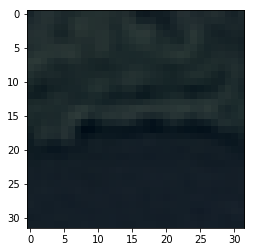

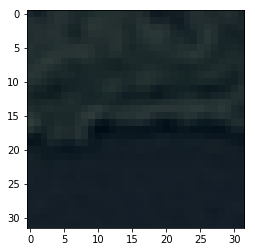

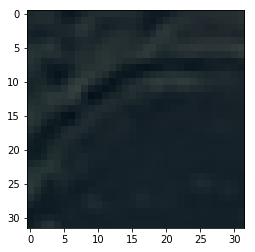

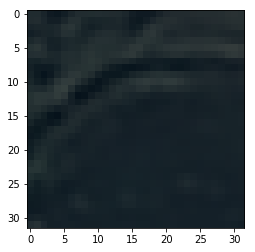

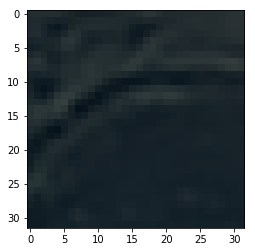

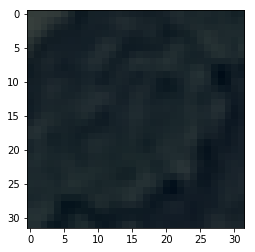

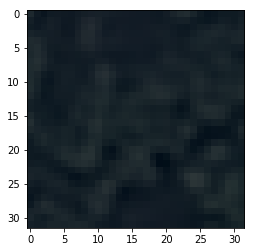

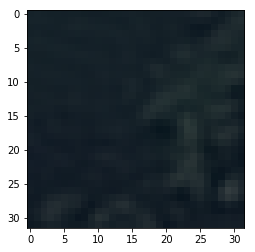

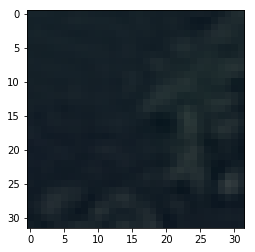

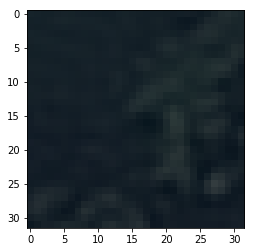

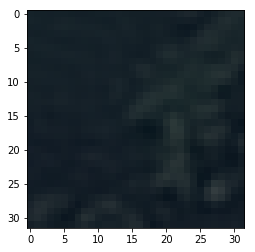

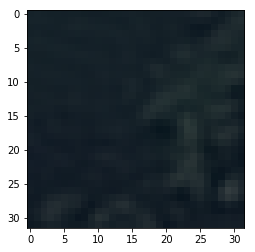

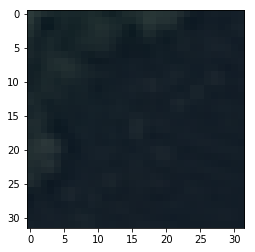

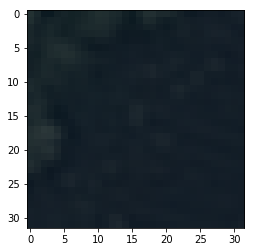

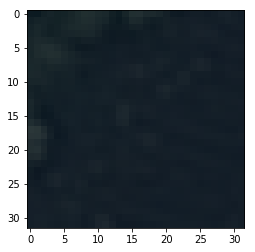

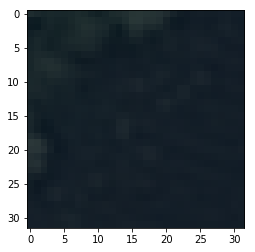

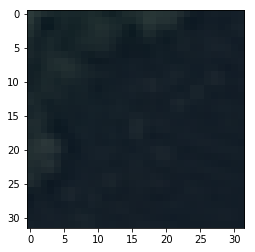

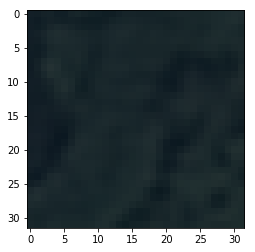

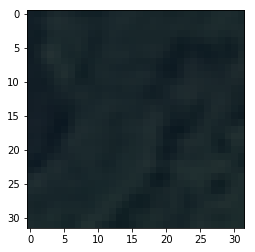

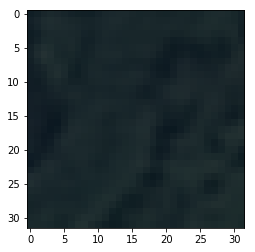

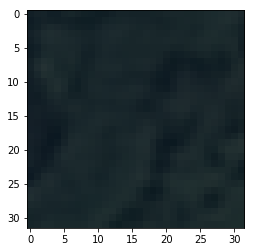

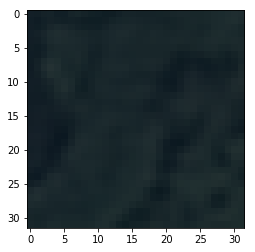

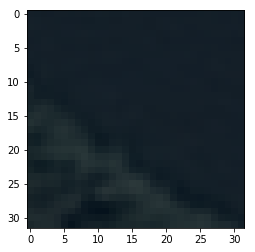

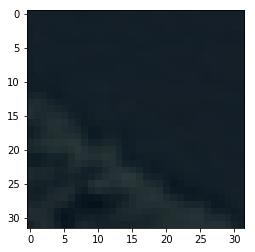

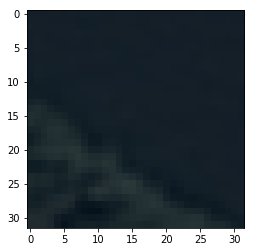

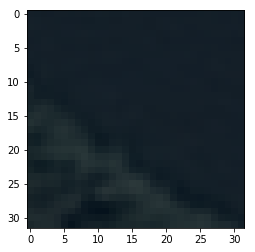

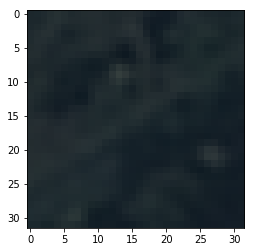

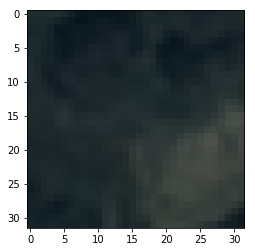

KeyboardInterrupt: 

In [26]:
annotations[annotations['label'] == "Water, Overig"].apply(lambda x:nso_tif_kernel.plot_kernel(x['kernel']), axis=1)

TypeError: Invalid dimensions for image data

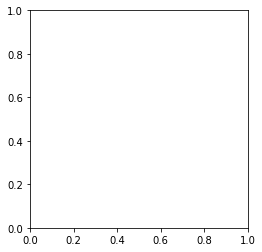

In [61]:
nso_tif_kernel.plot_kernel(annotations[annotations['label'] == "Water, Overig"][14:15]["kernel"].values[0])

In [77]:
np.median([annotations[annotations['label'] == "Mos"]['kernel'].values[0],annotations[annotations['label'] == "Mos"]['kernel'].values[1]], axis=1)

array([[[117. , 117.5, 119. , ...,  93.5,  97. ,  96. ],
        [117.5, 118.5, 120. , ...,  90. ,  93.5,  92.5],
        [116.5, 118. , 121. , ...,  86. ,  74.5,  74. ],
        ...,
        [ 41.5,  38.5,  36. , ...,  43.5,  56.5,  56.5],
        [ 40. ,  37.5,  34.5, ...,  42.5,  44. ,  44. ],
        [ 38.5,  37. ,  35. , ...,  41. ,  42. ,  42.5]],

       [[116.5, 118. , 121. , ...,  86. ,  74.5,  74. ],
        [117.5, 119. , 122.5, ...,  82. ,  70. ,  69.5],
        [121.5, 123. , 123.5, ...,  64. ,  43. ,  42.5],
        ...,
        [ 38.5,  37. ,  35. , ...,  41. ,  42. ,  42.5],
        [ 35.5,  35. ,  34.5, ...,  40. ,  41.5,  42. ],
        [ 32. ,  32. ,  33. , ...,  40. ,  41.5,  42. ]]])

In [305]:
np_array_median_annotation = np.array([])
for label in annotations['label'].unique():
    print(label)
    anno_shapes = []
    for shape in annotations[annotations['label'] == str(label)]['kernel'].values:
        try:
            if shape.shape == (2,32,32):
               anno_shapes.append(shape) 
        except:
            print("Faulty shape format")
        
    print(len(anno_shapes))
    
    np_array_median_annotation = np.append(np_array_median_annotation, np.array([label, np.median(np.array(anno_shapes), axis=0)]) )
  

Mos
25676


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Open laag struweel
Faulty shape format
Faulty shape format
25748
Zand
26579
Open Duindoorn
25455
Dicht Duindoorn
24900
Lage kruiden-gras
Faulty shape format
Faulty shape format
24775
Hoge kruiden-gras
25684
Dicht laag struweel
Faulty shape format
Faulty shape format
25343
Open Hoog Struweel
25417
Dicht Hoog Struweel
24745
Naaldbos
25068
Loofbos
Faulty shape format
Faulty shape format
Faulty shape format
Faulty shape format
25055
Adelaarsvaren
Faulty shape format
Faulty shape format
Faulty shape format
Faulty shape format
Faulty shape format
Faulty shape format
Faulty shape format
Faulty shape format
Faulty shape format
Faulty shape format
26076
Heide
Faulty shape format
Faulty shape format
Faulty shape format
Faulty shape format
Faulty shape format
Faulty shape format
Faulty shape format
Faulty shape format
Faulty shape format
Faulty shape format
Faulty shape format
Faulty shape format
Faulty shape format
Faulty shape format
Faulty shape format
Faulty shape format
Faulty shape format
F

In [306]:
np_array_median_annotation = np_array_median_annotation.reshape(16,2)

In [307]:
for label in np_array_median_annotation:
    print("---")
    print(label[0])
    print(" NDVI:")
    print(sum(sum(label[1][0])))
    print(" AHN:")
    print(sum(sum(label[1][1])))

---
Mos
 NDVI:
77730.0
 AHN:
2190.5
---
Open laag struweel
 NDVI:
88481.0
 AHN:
25539.5
---
Zand
 NDVI:
61835.0
 AHN:
19576.0
---
Open Duindoorn
 NDVI:
105946.0
 AHN:
36583.0
---
Dicht Duindoorn
 NDVI:
122700.5
 AHN:
60027.5
---
Lage kruiden-gras
 NDVI:
93366.0
 AHN:
21111.0
---
Hoge kruiden-gras
 NDVI:
100201.5
 AHN:
28125.5
---
Dicht laag struweel
 NDVI:
96590.0
 AHN:
34981.0
---
Open Hoog Struweel
 NDVI:
111628.0
 AHN:
68177.0
---
Dicht Hoog Struweel
 NDVI:
121592.0
 AHN:
76266.0
---
Naaldbos
 NDVI:
124332.5
 AHN:
188949.0
---
Loofbos
 NDVI:
140254.0
 AHN:
150633.0
---
Adelaarsvaren
 NDVI:
176570.0
 AHN:
17886.5
---
Heide
 NDVI:
106851.5
 AHN:
1578.0
---
Water, Overig
 NDVI:
101519.5
 AHN:
44929.5
---
Riet
 NDVI:
151600.0
 AHN:
68513.0


In [308]:
np.save("median_annotation.npy",np_array_median_annotation)

In [96]:
np.load("median_annotation.npy",allow_pickle=True)

array([['Mos',
        array([[[117. , 117.5, 119. , ...,  93.5,  97. ,  96. ],
                [117.5, 118.5, 120. , ...,  90. ,  93.5,  92.5],
                [116.5, 118. , 121. , ...,  86. ,  74.5,  74. ],
                ...,
                [ 41.5,  38.5,  36. , ...,  43.5,  56.5,  56.5],
                [ 40. ,  37.5,  34.5, ...,  42.5,  44. ,  44. ],
                [ 38.5,  37. ,  35. , ...,  41. ,  42. ,  42.5]],

               [[116.5, 118. , 121. , ...,  86. ,  74.5,  74. ],
                [117.5, 119. , 122.5, ...,  82. ,  70. ,  69.5],
                [121.5, 123. , 123.5, ...,  64. ,  43. ,  42.5],
                ...,
                [ 38.5,  37. ,  35. , ...,  41. ,  42. ,  42.5],
                [ 35.5,  35. ,  34.5, ...,  40. ,  41.5,  42. ],
                [ 32. ,  32. ,  33. , ...,  40. ,  41.5,  42. ]]]),
        'Open laag struweel',
        array([[[73. , 72.5, 45.5, ..., 35. , 36.5, 39.5],
                [72.5, 72. , 46. , ..., 33. , 33.5, 36.5],
          

In [309]:
np_array_median_annotation

array([['Mos', array([[[77., 77., 77., ..., 78., 78., 78.],
                       [77., 77., 77., ..., 78., 78., 78.],
                       [77., 77., 77., ..., 77., 77., 77.],
                       ...,
                       [73., 73., 73., ..., 76., 76., 76.],
                       [74., 74., 74., ..., 76., 76., 76.],
                       [74., 74., 74., ..., 76., 76., 77.]],

                      [[ 1.,  1.,  1., ...,  1.,  1.,  1.],
                       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
                       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
                       ...,
                       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
                       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
                       [ 1.,  1.,  1., ...,  1.,  1.,  1.]]])],
       ['Open laag struweel',
        array([[[84., 84., 84., ..., 85., 84., 85.],
                [84., 85., 85., ..., 85., 85., 85.],
                [85., 85., 85., ..., 85., 85., 85.],
                ...,
        

In [310]:
predict(tif_kernel_generator.get_kernel_for_x_y(9351,6671),np_array_median_annotation)

'Riet'

In [311]:
def euclidean_distance_kernels(kernel_x, kernel_y):
    return np.sum(np.abs(kernel_x - kernel_y))

In [318]:
def predict(kernel,annotations, fade = True):
    
    if fade == True:
        return annotations[np.argmin([euclidean_distance_kernels(tif_kernel_generator.fadify_kernel(label[1]),\
                                                                 tif_kernel_generator.fadify_kernel(kernel))\
               for label in annotations])][0]
    elif fade == False:
        return annotations[np.argmin([euclidean_distance_kernels(label[1],\
                                                                 kernel)\
                   for label in annotations])][0]

In [313]:
tif_kernel_generator.set_fade_kernel(bands=2)

In [319]:
annotations['predict'] = annotations.apply(lambda x: predict(x['kernel'],np_array_median_annotation, False), axis=1)

In [321]:
len(annotations[annotations['label'] == annotations['predict']])/len(annotations)

0.35729558770684616

In [336]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    figure(figsize=(10, 6), dpi=80)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(annotations['label'].unique()))
    plt.xticks(tick_marks, annotations['label'].unique(), rotation=45)
    plt.yticks(tick_marks, annotations['label'].unique())
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [326]:
annotations['label'].unique()

array(['Mos', 'Open laag struweel', 'Zand', 'Open Duindoorn',
       'Dicht Duindoorn', 'Lage kruiden-gras', 'Hoge kruiden-gras',
       'Dicht laag struweel', 'Open Hoog Struweel', 'Dicht Hoog Struweel',
       'Naaldbos', 'Loofbos', 'Adelaarsvaren', 'Heide', 'Water, Overig',
       'Riet'], dtype=object)

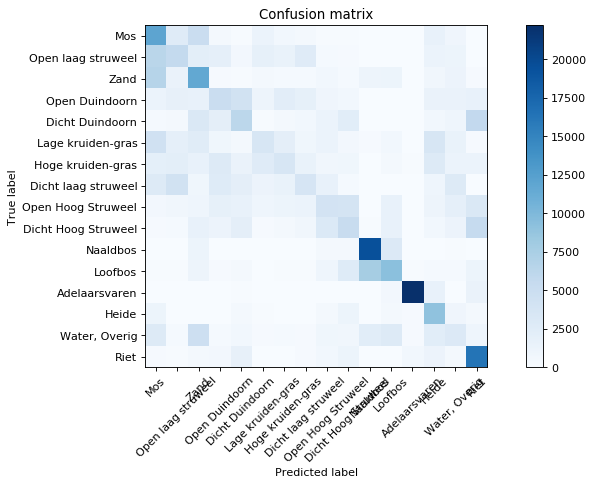

In [337]:
plot_confusion_matrix(confusion_matrix(annotations['label'],annotations['predict'], labels = annotations['label'].unique()))

In [186]:
def sum_sum_ndvi(x):
    try:
        sum(sum(x["kernel"]))
    except:
        return 0

In [198]:
annotations.apply(lambda x:sum_sum_ndvi(x['kernel'][0][0]), axis=1)

TypeError: 'int' object is not subscriptable

In [ ]:
bx= 0

In [203]:
ndvi_array = []
for id,row in annotations.iterrows():
    try:
        ndvi_array.append(sum(sum(row['kernel'][0])))
    except:
        ndvi_array.append(0)

In [205]:
annotations['ndvi_sum'] = ndvi_array

In [206]:

ahn_array = []
for id,row in annotations.iterrows():
    try:
        ahn_array.append(sum(sum(row['kernel'][1])))
    except:
        ahn_array.append(0)

In [207]:
annotations['ahn_sum'] = ahn_array

In [213]:
annotations

,label,x,y,cor_x,cor_y,kernel,predict,ndvi_sum,ahn_sum
0,Mos,93927.25,479552.75,14979,2643,"[[[117, 118, 118, 118, 122, 129, 129, 129, 129...",Mos,93726,42608
1,Mos,93927.25,479551.75,14981,2643,"[[[118, 121, 123, 124, 128, 131, 130, 130, 133...",Mos,89697,35952
2,Mos,93928.25,479551.75,14981,2645,"[[[123, 124, 128, 131, 130, 130, 133, 135, 135...",Mos,87347,32960
3,Mos,93928.25,479552.75,14979,2645,"[[[118, 118, 122, 129, 129, 129, 129, 128, 128...",Mos,91264,39420
4,Mos,93927.25,479552.75,14979,2643,"[[[117, 118, 118, 118, 122, 129, 129, 129, 129...",Mos,93726,42608
...,...,...,...,...,...,...,...,...,...
392376,Riet,95940.25,482367.75,9349,6669,"[[[86, 112, 136, 143, 148, 155, 163, 168, 168,...",Heide,130482,77192
392377,Riet,95940.25,482366.75,9351,6669,"[[[75, 95, 119, 137, 145, 150, 156, 160, 163, ...",Heide,129831,74804
392378,Riet,95941.25,482366.75,9351,6671,"[[[119, 137, 145, 150, 156, 160, 163, 167, 167...",Heide,134741,84280
392379,Riet,95941.25,482367.75,9349,6671,"[[[136, 143, 148, 155, 163, 168, 168, 169, 168...",Heide,135069,86736


In [212]:
for label in annotations['label'].unique():
    print("--------")
    print(label)
    annotations_cur = annotations[annotations['label'] == str(label)]
    
    print(annotations_cur['ndvi_sum'].mean())
    print(annotations_cur['ndvi_sum'].median())
    
    print(annotations_cur['ahn_sum'].mean())
    print(annotations_cur['ahn_sum'].median())

--------
Mos
78382.7533104845
77112.0
19558.322752765227
16184.0
--------
Open laag struweel
86857.28493203883
87369.0
25973.28100970874
24610.0
--------
Zand
65303.36645471989
65280.0
37074.01346928026
20824.0
--------
Open Duindoorn
102338.7270870163
105694.0
39428.90567668434
37340.0
--------
Dicht Duindoorn
108595.89485943776
121372.0
55606.455341365465
56042.0
--------
Lage kruiden-gras
90983.93380958146
94085.0
36320.949832505954
26440.0
--------
Hoge kruiden-gras
99901.18291543373
100949.0
36881.6638374085
30898.0
--------
Dicht laag struweel
94851.17001380943
94850.0
34907.89536397711
32628.0
--------
Open Hoog Struweel
112164.11952630129
111090.0
64929.332612031314
61648.0
--------
Dicht Hoog Struweel
116038.69412002424
120396.0
72284.68332996564
71200.0
--------
Naaldbos
104549.8426280517
124770.0
168538.55864049785
176204.0
--------
Loofbos
128568.14206472725
137759.0
132762.4496188994
132880.0
--------
Adelaarsvaren
170199.3132331519
173697.0
29290.241470520585
20900.0
----